# Session 7: Biological Learning

## About this tutorial
In this tutorial you will see how spike-timing-dependent plasticity (STDP), a Hebbian-like learning rule for spiking neurons, can be used to train a spiking feedforward network on an image classification task. The exercises presented here were developed by Matthieu Gilson and are based on examples in [Brian2: Spike-timing dependent plasticity](https://brian2.readthedocs.io/en/2.5.1/examples/synapses.STDP.html). 

First, we need to install the [Brian](https://briansimulator.org/) simulator. 

In [1]:
!pip install brian2 --quiet

In [2]:
from brian2 import *
import numpy as np
import struct
import matplotlib.pyplot as plt

## Loading data

Make sure the data is in the working directory.

In [3]:
data_dir = './' # 'data_MNIST/'

# use test set as data here
with open(data_dir+'t10k-images-idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    data = data.reshape((size, nrows, ncols))

with open(data_dir+'t10k-labels-idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    label = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))


data = np.array(data, dtype=float) / 255
label = np.array(label, dtype=int)

# select one digit (or several...)
if False:
    # select digit 3
    valid_train = label==3
else:
    # select digits 0 and 3, so PCA gets the common parts of digits 0 and 3
    valid_train = np.logical_or(label==9, label==3)
# select desired digits
data = data[valid_train,:]
label = label[valid_train]

P = valid_train.sum()


## Specify neuron parameters



In [4]:
#%% from SDTP example

N = 28**2
taum = 10*ms
taupre = 20*ms
taupost = taupre
Ee = 0*mV
vt = -54*mV
vr = -60*mV
El = -74*mV
taue = 5*ms
gmax = 0.12
dApre = 0.001
dApost = -dApre * taupre / taupost * 1.05
dBpre = 0.01
dBpost = -0.01
dApost *= gmax
dApre *= gmax
dBpre *= gmax
dBpost *= gmax

eqs_neurons = '''
dv/dt = (ge * (Ee-v) + El - v) / taum : volt
dge/dt = -ge / taue : 1
'''


## Define functions

We need a function to prepare inputs to the network and another function to perform simulations. Have a good look at these functions.

In [5]:
def get_input(t):
    # reshape image in 1D vector
    x = data[t,:,:].reshape([N]) * 6.0
    return x

def sim(pat_ind):
    poisson_inputs = PoissonGroup(N, rates=1*Hz)
    neurons = NeuronGroup(1, eqs_neurons, threshold='v>vt', reset='v = vr',
                          method='euler')
    S = Synapses(poisson_inputs, neurons,
                  '''w : 1
                     dApre/dt = -Apre / taupre : 1 (event-driven)
                     dApost/dt = -Apost / taupost : 1 (event-driven)
                  ''',
                on_pre='''ge += w
                          Apre += dApre
                          w = clip(w + Apost + dBpre, 0, gmax)
                       ''',
                on_post='''Apost += dApost
                            w = clip(w + Apre + dBpost, 0, gmax)
                        ''',
                 )
    S.connect()
    S.w = 'rand() * gmax'
    
    n_rep = pat_ind.size
    w_hist = np.zeros([n_rep,N])
    r_hist = np.zeros([n_rep,2])
    
    # loop over all digits
    for i, p in enumerate(pat_ind):
        # init monitors
        in_rate_monitor = PopulationRateMonitor(poisson_inputs)
        out_rate_monitor = PopulationRateMonitor(neurons)
        # calculate output from input
        x = get_input(p)
        poisson_inputs.rates = x*Hz
        # Oja's rule
        run(1*second, report='text')
        # monitoring
        w_hist[i,:] = np.copy(S.w)
        r_hist[i,0] = np.copy((in_rate_monitor.rate/Hz).mean())
        r_hist[i,1] = np.copy((out_rate_monitor.rate/Hz).mean())
        
    
    
    return w_hist, r_hist

## Perform simulations

In [6]:
w_hist, r_hist = sim(np.arange(100))

WARNING    Removing unsupported flag '-w' from compiler flags. [brian2.codegen.cpp_prefs]
WARNING    Removing unsupported flag '-O3' from compiler flags. [brian2.codegen.cpp_prefs]
WARNING    Removing unsupported flag '-ffast-math' from compiler flags. [brian2.codegen.cpp_prefs]
WARNING    Removing unsupported flag '-fno-finite-math-only' from compiler flags. [brian2.codegen.cpp_prefs]
WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]
WARNING    Removing unsupported flag '-std=c++11' from compiler flags. [brian2.codegen.cpp_prefs]
WARNING    Cannot use Cython, a test compilation failed: command 'gcc' failed: No such file or directory (CompileError)
Certain compiler configurations (e.g. clang in a conda environment on OS X) are known to be problematic. Note that you can switch the compiler by setting the 'CC' and 'CXX' environment variables. For example, you may want to try 'CC=gcc' and 'CXX=g++'. [brian2.codegen.runtime.cython_rt.cytho

Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 5s
Starting simulation at t=1. s for a duration of 1. s
1. s (100%) simulated in 5s
Starting simulation at t=2. s for a duration of 1. s
1. s (100%) simulated in 5s
Starting simulation at t=3. s for a duration of 1. s
1. s (100%) simulated in 5s
Starting simulation at t=4. s for a duration of 1. s
1. s (100%) simulated in 5s
Starting simulation at t=5. s for a duration of 1. s
1. s (100%) simulated in 5s
Starting simulation at t=6. s for a duration of 1. s
1. s (100%) simulated in 5s
Starting simulation at t=7. s for a duration of 1. s
1. s (100%) simulated in 5s
Starting simulation at t=8. s for a duration of 1. s
1. s (100%) simulated in 5s
Starting simulation at t=9. s for a duration of 1. s
1. s (100%) simulated in 5s
Starting simulation at t=10. s for a duration of 1. s
1. s (100%) simulated in 5s
Starting simulation at t=11. s for a duration of 1. s
1. s (100%) simulated in 5s
Starting simulation at t=1

## Plot results

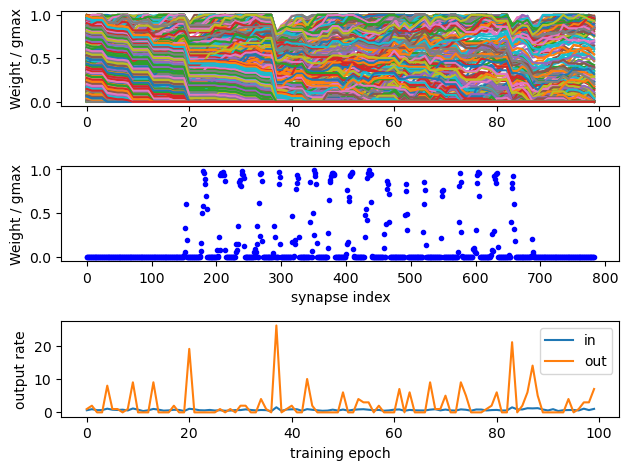

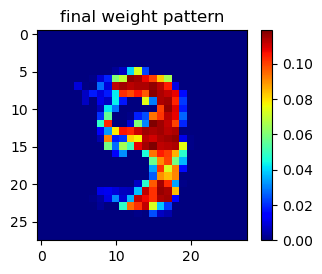

In [7]:
plt.subplot(311)
plt.plot(w_hist / gmax)
plt.ylabel('Weight / gmax')
plt.xlabel('training epoch')
plt.subplot(312)
plt.plot(w_hist[-1,:] / gmax, '.b')
plt.xlabel('synapse index')
plt.ylabel('Weight / gmax')
plt.subplot(313)
plt.plot(r_hist)
plt.legend(['in','out'])
plt.xlabel('training epoch')
plt.ylabel('output rate')
plt.tight_layout()
plt.savefig('STDP_evol')

# final pattern of weights in 2D
w_aff = w_hist[-1,:].reshape([28,28]) # average over 100 last time steps
plt.figure(figsize=[4,3])
plt.axes([0.2,0.2,0.7,0.7])
plt.imshow(w_aff, aspect=1, cmap='jet')
plt.title('final weight pattern')
plt.colorbar()
plt.savefig('STDP_final_w_pattern')

plt.show()
